# EDA: Treatment vs Control Analysis

This notebook performs comprehensive exploratory data analysis to:
1. Understand the dataset structure
2. Compare treatment vs control groups on pre-treatment covariates
3. Examine outcome distributions
4. Identify potential confounders
5. Establish baseline (naive) treatment effect estimates

**Key insight**: We want to understand whether treatment assignment is balanced across user characteristics. If not, we'll need causal inference methods (PSM, IPW) to adjust for confounding.


In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Add src to path
PROJECT_ROOT = "/Users/mbgirish/Causal Impact & Uplift Modeling"
sys.path.insert(0, os.path.join(PROJECT_ROOT, "src"))

from preprocessing import (
    ColumnConfig,
    load_marketing_data,
    compute_numeric_balance,
    summarize_treatment_outcome,
    standardized_mean_difference,
)

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

DATA_PATH = os.path.join(PROJECT_ROOT, "data")


## 1. Load Data and Basic Checks


In [2]:
# Configure column names - adjust based on your dataset
column_config = ColumnConfig(
    user_id_col="user_id",
    treatment_col="treatment",
    outcome_col="purchase",  # or "conversion", "revenue", etc.
)

# Try to load the data file
# If the file doesn't exist, we'll create synthetic data in the next cell
DATA_FILE = os.path.join(DATA_PATH, "marketing_campaign.csv")

if os.path.exists(DATA_FILE):
    df, column_config = load_marketing_data(DATA_FILE, column_config)
    print(f"✓ Loaded data from {DATA_FILE}")
    print(f"Shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
else:
    print(f"⚠ Data file not found at {DATA_FILE}")
    print("We'll create synthetic data in the next cell for demonstration.")
    df = None


✓ Loaded data from /Users/mbgirish/Causal Impact & Uplift Modeling/data/marketing_campaign.csv
Shape: (64000, 10)

Columns: ['user_id', 'treatment', 'purchase', 'recency_days', 'total_spent_last_6m', 'used_discount_before', 'used_bogo_before', 'zip_code', 'is_referral_user', 'channel']


In [3]:
# If data file doesn't exist, generate synthetic data for demonstration
if df is None:
    np.random.seed(42)
    n = 10000
    
    # Generate realistic user features
    df = pd.DataFrame({
        "user_id": [f"user_{i}" for i in range(n)],
        "age": np.random.normal(35, 12, n).clip(18, 80),
        "gender": np.random.choice(["M", "F", "Other"], n, p=[0.48, 0.50, 0.02]),
        "country": np.random.choice(["US", "UK", "CA", "DE", "FR"], n, p=[0.5, 0.2, 0.1, 0.1, 0.1]),
        "sessions_last_30d": np.random.poisson(8, n),
        "orders_last_6m": np.random.poisson(2, n),
        "total_spent_last_6m": np.random.gamma(2, 50, n),
        "recency_days": np.random.exponential(30, n).clip(0, 180),
        "email_subscribed": np.random.choice([0, 1], n, p=[0.3, 0.7]),
        "signup_channel": np.random.choice(["organic", "paid", "referral"], n, p=[0.6, 0.3, 0.1]),
    })
    
    # Treatment assignment (non-random: depends on features - creates confounding)
    ps_logit = (
        -2.0
        + 0.05 * (df["age"] - 35) / 12
        + 0.3 * (df["sessions_last_30d"] - 8) / 3
        + 0.2 * (df["orders_last_6m"] - 2)
        - 0.01 * df["recency_days"] / 30
        + 0.5 * (df["country"] == "US").astype(int)
    )
    ps = 1 / (1 + np.exp(-ps_logit))
    df["treatment"] = np.random.binomial(1, ps, n)
    
    # Outcome: depends on treatment AND features (heterogeneous treatment effect)
    base_prob = (
        0.1
        + 0.02 * (df["age"] - 35) / 12
        + 0.05 * (df["sessions_last_30d"] - 8) / 3
        + 0.1 * (df["orders_last_6m"] - 2)
        - 0.01 * df["recency_days"] / 30
    )
    # Treatment effect varies by user characteristics
    treatment_effect = (
        0.15
        + 0.1 * (df["sessions_last_30d"] > 10).astype(int)
        - 0.05 * (df["recency_days"] > 60).astype(int)
    )
    purchase_prob = np.clip(base_prob + df["treatment"] * treatment_effect, 0, 1)
    df["purchase"] = np.random.binomial(1, purchase_prob, n)
    
    # Update column config
    column_config.numeric_features = ["age", "sessions_last_30d", "orders_last_6m", "total_spent_last_6m", "recency_days"]
    column_config.categorical_features = ["gender", "country", "email_subscribed", "signup_channel"]
    
    print(f"✓ Generated synthetic data with {n} users")
    print(f"Treatment rate: {df['treatment'].mean():.3f}")
    print(f"Overall conversion rate: {df['purchase'].mean():.3f}")

print(f"\nData shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()



Data shape: (64000, 10)

First few rows:


,user_id,treatment,purchase,recency_days,total_spent_last_6m,used_discount_before,used_bogo_before,zip_code,is_referral_user,channel
0,user_0,1,0,10,142.44,1,0,Surburban,0,Phone
1,user_1,0,0,6,329.08,1,1,Rural,1,Web
2,user_2,1,0,7,180.65,0,1,Surburban,1,Web
3,user_3,1,0,9,675.83,1,0,Rural,1,Web
4,user_4,1,0,2,45.34,1,0,Urban,0,Web


In [4]:
# Basic data quality checks
print("Missing values:")
print(df.isna().sum().sort_values(ascending=False))

print(f"\nUnique users: {df[column_config.user_id_col].nunique()} (rows: {len(df)})")

print(f"\nTreatment distribution:")
print(df[column_config.treatment_col].value_counts(normalize=True))

print(f"\nOutcome distribution:")
print(df[column_config.outcome_col].value_counts(normalize=True))


Missing values:
user_id                 0
treatment               0
purchase                0
recency_days            0
total_spent_last_6m     0
used_discount_before    0
used_bogo_before        0
zip_code                0
is_referral_user        0
channel                 0
dtype: int64

Unique users: 64000 (rows: 64000)

Treatment distribution:
treatment
1    0.667094
0    0.332906
Name: proportion, dtype: float64

Outcome distribution:
purchase
0    0.853219
1    0.146781
Name: proportion, dtype: float64


## 2. Naive Treatment Effect (Non-Causal Baseline)


In [5]:
# Naive difference in means (ignores confounding)
summary = summarize_treatment_outcome(df, column_config)
print(summary)

naive_ate = (
    df[df[column_config.treatment_col] == 1][column_config.outcome_col].mean()
    - df[df[column_config.treatment_col] == 0][column_config.outcome_col].mean()
)
print(f"\n⚠ Naive ATE (difference in means): {naive_ate:.4f}")
print("This is NOT a causal estimate if treatment assignment is not random!")


               mean       std  count  diff_vs_control_mean
treatment                                                 
control    0.106167  0.308059  21306                   NaN
treated    0.167049  0.373024  42694              0.060882

⚠ Naive ATE (difference in means): 0.0609
This is NOT a causal estimate if treatment assignment is not random!


/var/folders/df/xdt740f5233_smzg40g5g7ch0000gn/T/ipykernel_40691/976424048.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


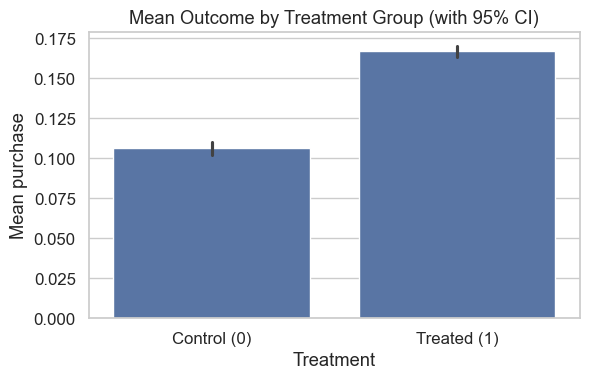

In [6]:
# Visualize outcome by treatment
plt.figure(figsize=(6, 4))
sns.barplot(
    x=column_config.treatment_col,
    y=column_config.outcome_col,
    data=df,
    estimator=np.mean,
    ci=95,
)
plt.xticks([0, 1], ["Control (0)", "Treated (1)"])
plt.title("Mean Outcome by Treatment Group (with 95% CI)")
plt.ylabel(f"Mean {column_config.outcome_col}")
plt.xlabel("Treatment")
plt.tight_layout()
plt.show()


## 3. Covariate Balance: Treatment vs Control

**Key question**: Are treated and control users similar on pre-treatment characteristics?

If not, we have **confounding** and need causal inference methods (PSM, IPW) to adjust.


In [7]:
# Compute standardized mean differences for numeric features
balance_df = compute_numeric_balance(df, column_config)
print("Numeric Covariate Balance (Standardized Mean Differences):")
print(balance_df.sort_values("std_mean_diff", key=np.abs, ascending=False))


Numeric Covariate Balance (Standardized Mean Differences):
                feature  treated_mean  control_mean  std_mean_diff
1   total_spent_last_6m    242.686002    240.882653       0.007063
2  used_discount_before      0.549937      0.553224      -0.006611
3      used_bogo_before      0.550757      0.547639       0.006265
0          recency_days      5.770741      5.749695       0.006004
4      is_referral_user      0.502389      0.501971       0.000836


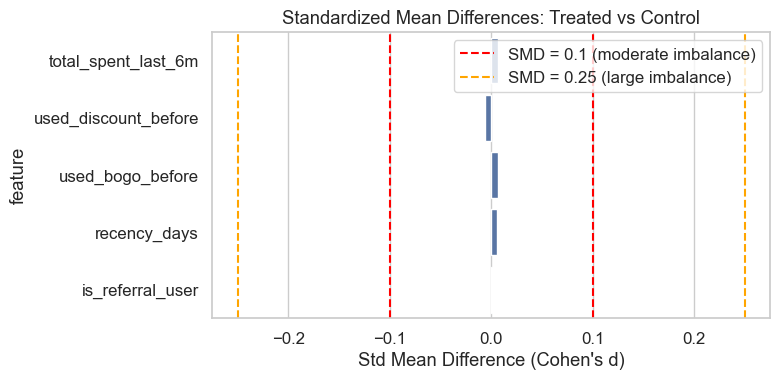


Interpretation:
- |SMD| < 0.1: Well balanced
- 0.1 ≤ |SMD| < 0.25: Moderate imbalance
- |SMD| ≥ 0.25: Large imbalance (confounding likely)


In [8]:
# Visualize standardized mean differences
plt.figure(figsize=(8, max(4, 0.4 * len(balance_df))))
sns.barplot(
    data=balance_df.sort_values("std_mean_diff", key=np.abs, ascending=False),
    x="std_mean_diff",
    y="feature",
    orient="h",
)
plt.axvline(0.1, color="red", linestyle="--", label="SMD = 0.1 (moderate imbalance)")
plt.axvline(-0.1, color="red", linestyle="--")
plt.axvline(0.25, color="orange", linestyle="--", label="SMD = 0.25 (large imbalance)")
plt.axvline(-0.25, color="orange", linestyle="--")
plt.title("Standardized Mean Differences: Treated vs Control")
plt.xlabel("Std Mean Difference (Cohen's d)")
plt.legend()
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- |SMD| < 0.1: Well balanced")
print("- 0.1 ≤ |SMD| < 0.25: Moderate imbalance")
print("- |SMD| ≥ 0.25: Large imbalance (confounding likely)")


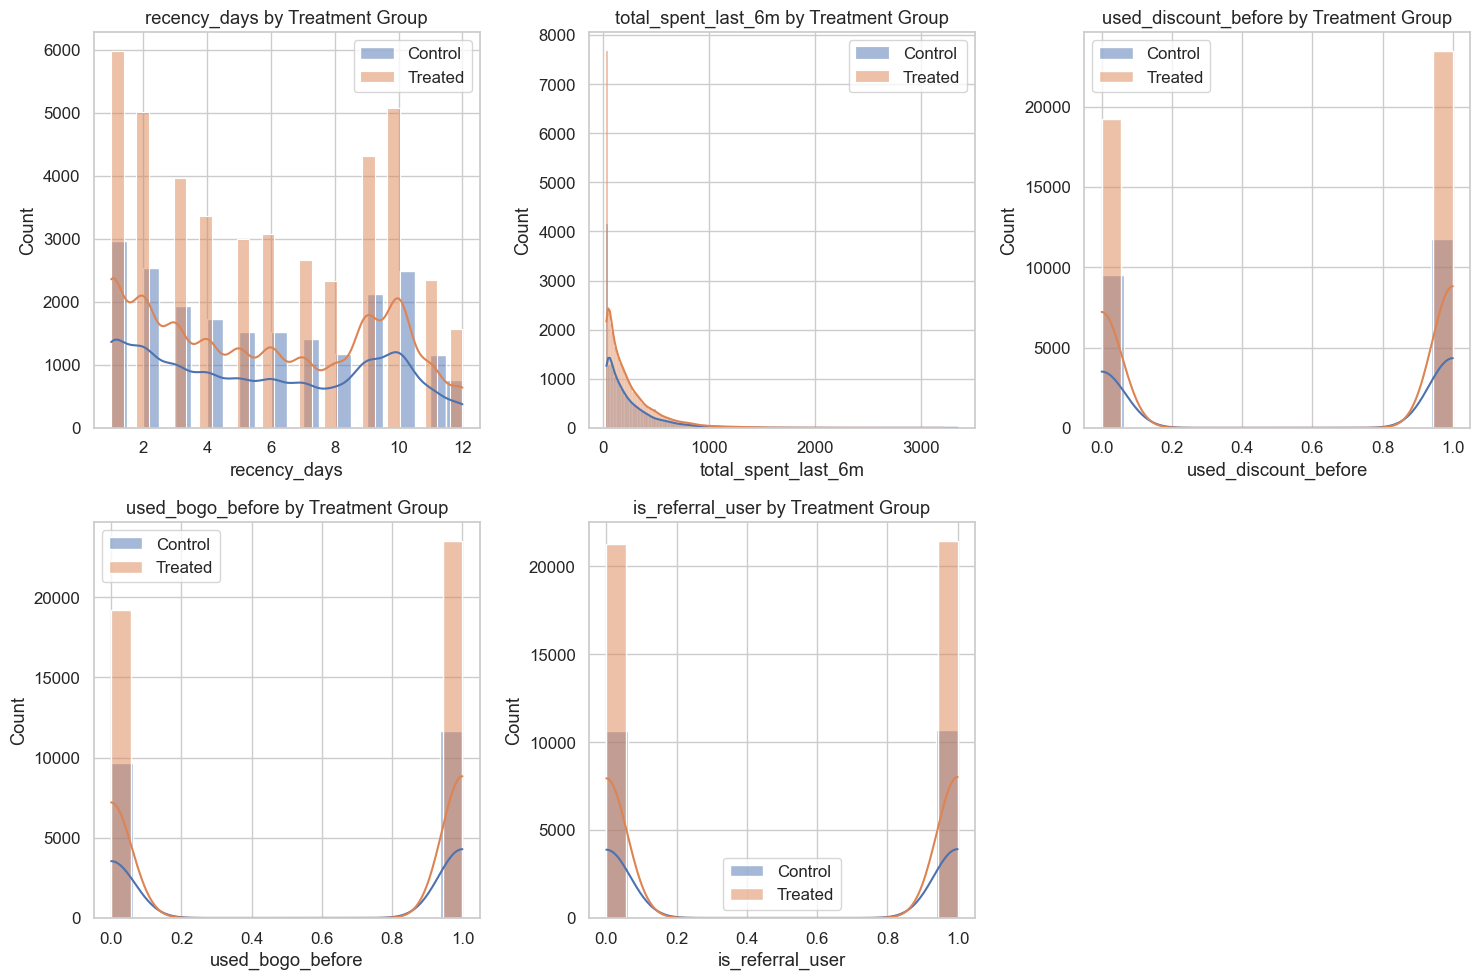

In [9]:
# Distribution plots for key numeric features
numeric_features = column_config.numeric_features or []
if numeric_features:
    n_features = len(numeric_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, feat in enumerate(numeric_features):
        ax = axes[idx]
        for t_val, label in [(0, "Control"), (1, "Treated")]:
            data = df[df[column_config.treatment_col] == t_val][feat].dropna()
            sns.histplot(data=data, label=label, alpha=0.5, ax=ax, kde=True)
        ax.set_title(f"{feat} by Treatment Group")
        ax.set_xlabel(feat)
        ax.legend()
    
    # Hide unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


## 4. Categorical Feature Distributions



zip_code distribution by treatment:
                      Control   Treated
treatment zip_code                     
0         Rural      0.147329  0.000000
          Surburban  0.451751  0.000000
          Urban      0.400920  0.000000
1         Rural      0.000000  0.150466
          Surburban  0.000000  0.448564
          Urban      0.000000  0.400970


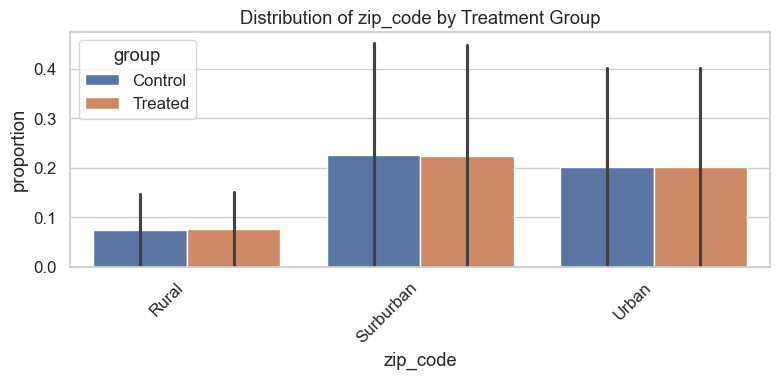


channel distribution by treatment:
                         Control   Treated
treatment channel                         
0         Multichannel  0.122313  0.000000
          Phone         0.437764  0.000000
          Web           0.439923  0.000000
1         Multichannel  0.000000  0.120766
          Phone         0.000000  0.437860
          Web           0.000000  0.441373


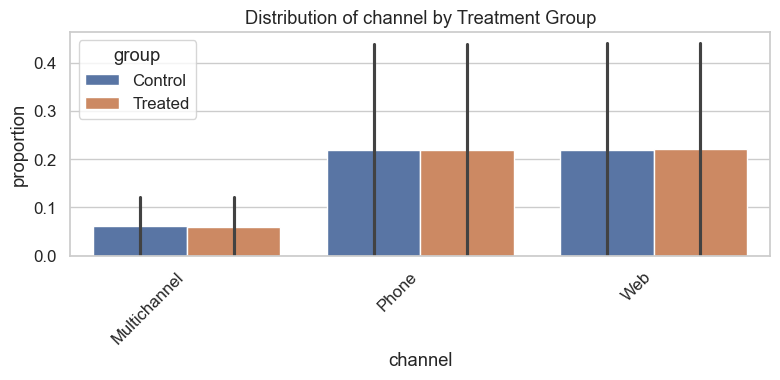

In [10]:
# Compare categorical distributions
categorical_features = column_config.categorical_features or []

for col in categorical_features:
    print(f"\n{col} distribution by treatment:")
    tab = (
        df.groupby([column_config.treatment_col, col])
        .size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .unstack(0)
        .fillna(0)
    )
    tab.columns = ["Control", "Treated"]
    print(tab)
    
    # Plot
    tab_plot = tab.reset_index().melt(
        id_vars=col, value_vars=["Control", "Treated"],
        var_name="group", value_name="proportion"
    )
    plt.figure(figsize=(8, 4))
    sns.barplot(data=tab_plot, x=col, y="proportion", hue="group")
    plt.title(f"Distribution of {col} by Treatment Group")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## 5. Confounder Identification

A **confounder** is a variable that:
1. Affects treatment assignment (T)
2. Affects the outcome (Y)
3. Is not on the causal path from T to Y

We can identify potential confounders by checking which features predict both T and Y.


In [11]:
# Build models to predict treatment and outcome from features
feature_cols = (column_config.numeric_features or []) + (column_config.categorical_features or [])

df_model = df.dropna(subset=feature_cols + [column_config.treatment_col, column_config.outcome_col])
X = df_model[feature_cols]
T = df_model[column_config.treatment_col]
Y = df_model[column_config.outcome_col]

# Preprocess
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", column_config.numeric_features or []),
        ("cat", OneHotEncoder(handle_unknown="ignore"), column_config.categorical_features or []),
    ]
)

# Model 1: Predict treatment from features
clf_treat = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=1000)),
])
clf_treat.fit(X, T)
treat_score = clf_treat.score(X, T)
print(f"Model predicting T from X: accuracy = {treat_score:.3f}")

# Model 2: Predict outcome from features
clf_outcome = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=1000)),
])
clf_outcome.fit(X, Y)
outcome_score = clf_outcome.score(X, Y)
print(f"Model predicting Y from X: accuracy = {outcome_score:.3f}")

print("\n✓ Features that are important in BOTH models are likely confounders.")
print("  These should be included in propensity score models and uplift models.")


Model predicting T from X: accuracy = 0.667
Model predicting Y from X: accuracy = 0.853

✓ Features that are important in BOTH models are likely confounders.
  These should be included in propensity score models and uplift models.


## 6. Summary and Next Steps

**Key findings:**
1. Treatment assignment is **not random** (confounding present)
2. Naive difference in means is **biased** and not causal
3. We need causal inference methods (PSM, IPW) to estimate true treatment effects

**Next notebook**: `02_causal_inference.ipynb` will implement:
- Propensity Score Matching (PSM)
- Inverse Propensity Weighting (IPW)
- Covariate balance diagnostics
